# WW3 Global Characteristic of SWH and WSP Seasonal cycle Least Square Fit Model with a 5 Parameter Fit

Plot figure within jupyter notebook

In [1]:
%matplotlib inline

Use the sys library in order to tell the notebook to look for files within the followinf directory path: 

In [2]:
import sys
sys.path.append('/zdata/home/lcolosi/python_functions/')

Import all libraries and functions

In [3]:
#libraries
import numpy as np #contains the major of functions used for matrix arrays  
import matplotlib.pyplot as plt # matplotlib contains functions for graphics and plot manipulation
from netCDF4 import Dataset, num2date # netCDF4 handles netCDF files
import datetime
#plotting libraries
import cmocean.cm as cmo
from matplotlib import cm 
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import ticker
import matplotlib
from numpy import pi

#my functions
from unweighted_least_square_fit import least_square_fit 
from char_LSF_curve import character_LSF
from monthly_mean import monthly_average
import cartopy_fig_module as cart

Set dimensions for data of space and time which depends on the spatial orientation of the data set and the time period which the data is collected from. For the Ifremer data set, we want the following data orientation: 

In [4]:
nt, nlon, nlat = 8400, 720, 265
initial_year = 1993
final_year = 2015
initial_mon = 1
final_mon = 12

Set filename and look at key variables and attributes

In [5]:
filename_hs = '/zdata/downloads/colosi_data_bk/binned_data/WW3/CFSR/lc_binned_data/ww3_hs_daily_binned_data_93_16.nc'
filename_wnd = '/zdata/downloads/colosi_data_bk/binned_data/WW3/CFSR/lc_binned_data/ww3_wnd_daily_binned_data_93_16.nc'

#set nc variable in order to read attributes and obtained data: 
nc_hs = Dataset(filename_hs, 'r')
nc_wnd = Dataset(filename_wnd, 'r')


#print key variables:
print(nc_hs.variables.keys())
print(nc_wnd.variables.keys())

#longitude
for at in nc_hs.variables['lon'].ncattrs():
    print("%s : %s" %(at, nc_hs.variables['lon'].getncattr(at)))

#laitude
for at in nc_hs.variables['lat'].ncattrs():
    print("%s : %s" %(at, nc_hs.variables['lat'].getncattr(at)))
    
#time 
for at in nc_hs.variables['time'].ncattrs():
    print("%s : %s" %(at, nc_hs.variables['time'].getncattr(at)))
    

odict_keys(['time', 'lon', 'lat', 'swh'])
odict_keys(['time', 'lon', 'lat', 'wsp'])
units : degrees east
units : degrees north
units : days since 1990-01-01 00:00:00
calendar : julian


Call Hs and WSP data from WW3 netcdf files 

In [6]:
hs = nc_hs.variables['swh'][:]
wsp = nc_wnd.variables['wsp'][:]
lat = nc_hs.variables['lat'][:]
lon = nc_hs.variables['lon'][:]
time = num2date(nc_hs.variables['time'][:], nc_hs.variables['time'].units)
print(lat.shape,lon.shape)

(265,) (720,)


Call data only from January 1st, 1993 to December 31st, 2015 

In [7]:
#find initial and final indices: 
#create year vector: 
years = np.array([y.year for y in time])

#creat boolean arrays and combine them: 
ind_time = years != 2016

#use the compress function to find all indices that do not lie in 1992 or 2016 and extract slices of matrix along the time axis from swh
swh_c = np.compress(ind_time, hs, axis = 0)
wsp_c = np.compress(ind_time, wsp, axis = 0)
print(swh_c.shape,wsp_c.shape)

#extract the time steps: 
time_c = time[ind_time]

(8400, 265, 720) (8400, 265, 720)


Deresolve each of the wsp 3D array such that the resolution of the figure matches that of Ifremer data

In [8]:
#import running mean library:
from running_mean import running_mean 

#reset nlon and nlat to i degree resolution: 
nlon_c = 360
nlat_c = 133

#initialize 3D array: 
swh_array_dr = np.ma.masked_all([nt, nlat_c, nlon_c])
wsp_array_dr = np.ma.masked_all([nt, nlat_c, nlon_c])

#loop through each of the matrices in the 3D array in order to deresolve each matrix one at a time:
for itime in range(0,nt,1):
    
    #call data from the 3D array 
    swh_array_d = swh_c[itime,:,:]
    wsp_array_d = wsp_c[itime,:,:]
    #preform the deresolution via convolution
    swh_dr = running_mean(data = swh_array_d, k_dim = [2, 2], task = 'deresolve', fill_val = 'mask')
    wsp_dr = running_mean(data = wsp_array_d, k_dim = [2, 2], task = 'deresolve', fill_val = 'mask')
    #Save running mean wsp into 3D array: 
    swh_array_dr[itime,:,:] = swh_dr
    wsp_array_dr[itime,:,:] = wsp_dr
    
#deresolve lon and lat: 
lat_c = running_mean(data = lat, k_dim = [2,1], task = 'deresolve', fill_val = 'none')
lon_c = running_mean(data = lon, k_dim = [2,1], task = 'deresolve', fill_val = 'none')

#fix lat_c
lat_c[132] = 66.25

print(wsp_array_dr.shape, np.ma.is_masked(wsp_array_dr))

(8400, 133, 360) True


Calculate the monthly averaged swh and wsp from 1993 to 2016

In [9]:
hs_month_data = monthly_average(date_time = time_c, data = swh_array_dr, fill_val = 'mask')
wsp_month_data = monthly_average(date_time = time_c, data = wsp_array_dr, fill_val = 'mask')

Save mean, meadian, standard deviation, and number of observations (will be later used to calculate the standard deviation of the mean) in separate np.array variables. Change each dictionary key from a list to a np.array:

In [10]:
#For swh: 
swh_monthly_mean = np.ma.array(hs_month_data['mean'])
swh_monthly_median = np.ma.array(hs_month_data['median'])
swh_monthly_std = np.ma.array(hs_month_data['std'])
swh_monthly_n = np.ma.array(hs_month_data['N'])

#For wsp:
wsp_monthly_mean = np.ma.array(wsp_month_data['mean'])
wsp_monthly_median = np.ma.array(wsp_month_data['median'])
wsp_monthly_std = np.ma.array(wsp_month_data['std'])
wsp_monthly_n = np.ma.array(wsp_month_data['N'])

Create a loop to go through each grid point and compute the unweighted least square fit and the characteristics of the fit (e.g. residual, amplitude, phase constant, and coefficient of determination) 

In [11]:
#initialize masked arrays to save data in: 
swh_rms_m = np.ma.masked_all([nlat_c, nlon_c])
swh_amp1_m = np.ma.masked_all([nlat_c, nlon_c])
swh_phase1_m = np.ma.masked_all([nlat_c, nlon_c])
swh_amp2_m = np.ma.masked_all([nlat_c, nlon_c])
swh_phase2_m = np.ma.masked_all([nlat_c, nlon_c])
swh_cod_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_rms_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_amp1_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_phase1_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_amp2_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_phase2_m = np.ma.masked_all([nlat_c, nlon_c])
wsp_cod_m = np.ma.masked_all([nlat_c, nlon_c])

for ilat in range(0,nlat_c):
    for ilon in range(0,nlon_c):
        
        #call data in monthly mean matrix for swh and wsp: 
        swh_grid = swh_monthly_mean[:,ilat,ilon]
        wsp_grid = wsp_monthly_mean[:,ilat,ilon]
        
        #place a conditional statement for swh that will ignore all time series that have less than 200 data points in the time series 
        #find non-masked values: 
        ival_swh = np.ma.nonzero(swh_grid)
        iswh = len(swh_grid[ival_swh])
        print(iswh)
        #place condition:
        if iswh > 46: 
            #detrend linear trend at grid point: 
            swh_trend, x_trend = least_square_fit(data = swh_grid, trend = 'linear', parameters = 2, 
                                                    period = 12, fill_val = 'mask')
            #remove linear trend: 
            swh_detrend = swh_grid-swh_trend
            
            #compute least square fit:
            swh_hfit, x_swh = least_square_fit(data = swh_detrend, trend = 'sinusoidal', parameters = 5, 
                                               period = 12, fill_val = 'mask')
            #compute characteristics of least square fit
            swh_rms, swh_amp1, swh_phase1, swh_amp2, swh_phase2, swh_cod = character_LSF(data = swh_detrend, model = swh_hfit, x_solution = x_swh, trend = 'sinusoidal', parameters = 5, fill_val = 'mask')
            #save each data into a 2D array:
            #For swh:
            swh_rms_m[ilat,ilon] = swh_rms
            swh_amp1_m[ilat,ilon] = swh_amp1
            swh_phase1_m[ilat,ilon] = swh_phase1
            swh_amp2_m[ilat,ilon] = swh_amp2
            swh_phase2_m[ilat,ilon] = swh_phase2
            swh_cod_m[ilat,ilon] = swh_cod
            
        #place a conditional statement for swh that will ignore all time series that have less than 200 data points in the time series 
        #find non-nan values: 
        ival_wsp = np.ma.nonzero(wsp_grid)
        iwsp = len(wsp_grid[ival_wsp])
        print(iwsp)
        #plcae condition:
        if iwsp > 46:    
            #detrend grid point: 
            wsp_trend, x_trend = least_square_fit(data = wsp_grid, trend = 'linear', parameters = 2, 
                                                    period = 12, fill_val = 'mask')
            #remove linear trend: 
            wsp_detrend = wsp_grid-wsp_trend
            
            #compute least square fit:
            wsp_hfit, x_wsp = least_square_fit(data = wsp_detrend, trend = 'sinusoidal', parameters = 5, 
                                               period = 12, fill_val = 'mask')
            #compute characteristics of least square fit
            wsp_rms, wsp_amp1, wsp_phase1, wsp_amp2, wsp_phase2, wsp_cod = character_LSF(data = wsp_detrend, model = wsp_hfit, x_solution = x_wsp, trend = 'sinusoidal', parameters = 5, fill_val = 'mask')
            #save each data into a 2D array:
            #For wsp:
            wsp_rms_m[ilat,ilon] = wsp_rms
            wsp_amp1_m[ilat,ilon] = wsp_amp1
            wsp_phase1_m[ilat,ilon] = wsp_phase1
            wsp_amp2_m[ilat,ilon] = wsp_amp2
            wsp_phase2_m[ilat,ilon] = wsp_phase2
            wsp_cod_m[ilat,ilon] = wsp_cod
        

210
210
208
208
206
206
203
203
202
202
207
207
210
210
212
212
209
209
206
206
205
205
203
203
197
197
199
199
192
192
195
195
198
198
199
199
195
195
192
192
193
193
194
194
193
193
190
190
189
189
190
190
185
185
184
184
186
186
187
187
189
189
190
190
191
191
193
193
197
197
195
195
199
199
203
203
205
205
211
211
214
214
213
213
216
216
218
218
215
215
213
213
204
204
201
201
212
212
218
218
248
248
276
276
276
276
120
120
120
120
276
276
276
276
239
239
197
197
179
179
181
181
180
180
182
182
180
180
180
180
183
183
195
195
199
199
204
204
202
202
182
182
183
183
175
175
176
176
183
183
189
189
193
193
193
193
198
198
204
204
227
227
251
251
212
212
183
183
211
211
239
239
275
275
276
276
276
276
236
236
211
211
268
268
275
275
271
271
276
276
276
276
0
0
0
0
276
276
276
276
276
276
276
276
276
276
0
0
0
0
244
244
245
245
218
218
241
241
276
276
276
276
276
276
120
120
276
276
276
276
255
255
210
210
143
143
148
148
193
193
260
260
274
274
242
242
267
267
265
265
269
269
269
269


193
186
186
188
188
189
189
191
191
194
194
196
196
196
196
196
196
203
203
209
209
212
212
216
216
217
217
221
221
224
224
224
224
219
219
218
218
216
216
216
216
219
219
219
219
216
216
216
216
217
217
214
214
216
216
220
220
220
220
221
221
222
222
223
223
223
223
220
220
222
222
221
221
225
225
224
224
232
232
235
235
233
233
234
234
233
233
236
236
234
234
235
235
238
238
239
239
235
235
235
235
233
233
238
238
240
240
239
239
239
239
238
238
242
242
241
241
240
240
241
241
242
242
241
241
240
240
241
241
243
243
246
246
255
255
255
255
255
255
254
254
258
258
256
256
258
258
256
256
259
259
256
256
257
257
253
253
258
258
260
260
257
257
262
262
262
262
260
260
266
266
273
273
274
274
269
269
266
266
264
264
265
265
267
267
264
264
264
264
266
266
267
267
259
259
248
248
244
244
251
251
251
251
257
257
252
252
246
246
246
246
243
243
241
241
244
244
244
244
248
248
257
257
262
262
263
263
265
265
269
269
270
270
268
268
272
272
271
271
270
270
271
271
273
273
273
273
274
274
274


228
244
244
259
259
269
269
272
272
273
273
272
272
270
270
264
264
259
259
254
254
240
240
233
233
224
224
222
222
221
221
224
224
226
226
222
222
221
221
220
220
216
216
217
217
217
217
220
220
217
217
213
213
229
229
224
224
229
229
227
227
225
225
228
228
224
224
226
226
227
227
223
223
221
221
222
222
220
220
225
225
228
228
233
233
232
232
235
235
235
235
239
239
248
248
251
251
255
255
261
261
266
266
269
269
270
270
272
272
272
272
270
270
270
270
269
269
272
272
274
274
274
274
273
273
272
272
270
270
273
273
274
274
272
272
273
273
272
272
272
272
273
273
273
273
275
275
275
275
274
274
272
272
274
274
274
274
273
273
273
273
270
270
272
272
272
272
271
271
272
272
275
275
275
275
275
275
276
276
276
276
276
276
276
276
275
275
276
276
275
275
275
275
274
274
273
273
273
273
273
273
271
271
270
270
269
269
269
269
270
270
270
270
270
270
270
270
271
271
273
273
275
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
275
276
276
274
274
275
275
276
276
276
276
276
276
276
276
275
275
274
274
276
276
276
276
276
276
276
276
276
276
274
274
273
273
273
273
274
274
275
275
274
274
273
273
274
274
269
269
267
267
266
266
265
265
261
261
260
260
260
260
260
260
262
262
264
264
264
264
262
262
264
264
263
263
264
264
265
265
264
264
270
270
273
273
275
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
240
240
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
240
240
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
240
240
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
276
276
276
276
276
276
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
0
0
0
0
0
0


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
36
36
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
0
0
276
276
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
240
240
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
36
36
36
36
36
36
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
36
36
36
36
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
240
240
240
240
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
36
36
276
276
276
276
276
276
0
0
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
240
240
240
240
240
240
240
240
276
276
276
276
275
275
275
275
276
276
240
240
240
240
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
240
240
276
276
276
276
0
0
276
276
273
273
273
273
275
275
276
276
276
276
276
276
276
276
276
276
276


276
276
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
248
248
246
246
232
232
276
276
271
271
273
273
274
274
275
275
274
274
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
275
275
273
273
271


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
270
270
262
262
263
263
261
261
256
256
255
255
257
257
263
263
268
268
270
270
270
270
260
260
262
262
269
269
274
274
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
36
36
36
36
36
36
36
36
197
197
197
197
199
199
198
198
213
213
262
262
272
272
258
258
275
275
276
276
272
272
276
276
276
276
276
276


276
276
276


Plot each of the characteristics of the least square fit

### WSP

###### RMS, Amplitude and Phase of annual cycle, Amplitude and phase of Semi-annual cycle, Coefficient of Determination subplot figure without Cartopy

Text(0.5, 1.0, 'Semi-Annual Phase')

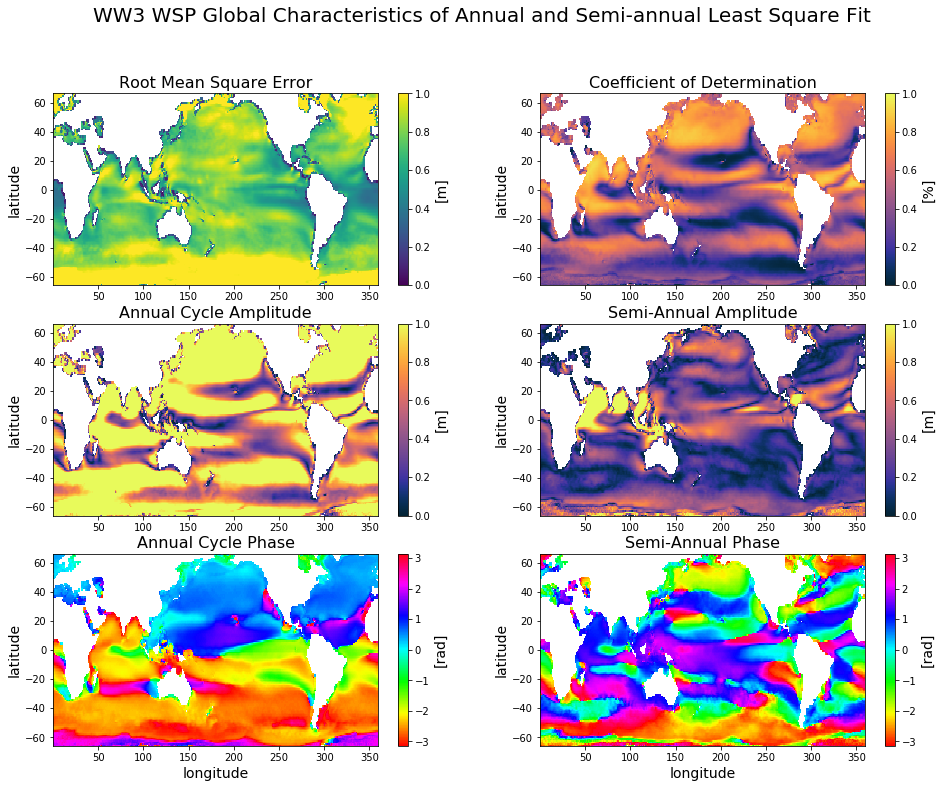

In [12]:
#initialize figure: 
fig2 = plt.figure(figsize=(16, 12))
fig2.suptitle('WW3 WSP Global Characteristics of Annual and Semi-annual Least Square Fit ', fontsize=20)

#RMS subplot: 
plt.subplot(321)
plt.pcolor(lon_c,lat_c,wsp_rms_m,vmin=0,vmax=1, cmap=cm.viridis)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Root Mean Square Error', fontsize=16)

#Coefficient of Determination subplot: 
plt.subplot(322)
plt.pcolor(lon_c,lat_c,wsp_cod_m,vmin=0,vmax=1, cmap=cmo.thermal)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[%]', fontsize=14)
#label figure 
plt.title('Coefficient of Determination', fontsize=16)

#Annual Amplitude subplot: 
plt.subplot(323)
plt.pcolor(lon_c,lat_c,wsp_amp1_m,vmin=0,vmax=1, cmap=cmo.thermal)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Annual Cycle Amplitude', fontsize=16)

#Semi-annual Amplitude subplot: 
plt.subplot(324)
plt.pcolor(lon_c,lat_c,wsp_amp2_m,vmin=0,vmax=1, cmap=cmo.thermal)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Semi-Annual Amplitude', fontsize=16)

#Annual Phase subplot: 
plt.subplot(325)
plt.pcolor(lon_c,lat_c,wsp_phase1_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[rad]', fontsize=14)
#label figure 
plt.title('Annual Cycle Phase', fontsize=16)

#Semi-annual Phase subplot: 
plt.subplot(326)
plt.pcolor(lon_c,lat_c,wsp_phase2_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[rad]', fontsize=14)
#label figure 
plt.title('Semi-Annual Phase', fontsize=16)


In [13]:
def set_subplots_c(ax, projection, resolution, lon_min, lon_max, lat_min, lat_max):
    
    """
    set_subplots(ax, projection)
    
        Function for placing x and y axes labels for longitude and latitude respectively
        
        Parameters 
        ----------
        ax : geospatial axes for the subplot (cartopy object)
               e.g. fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
                    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten() 
        lon_min, lon_max : minimum and maximum extent for longitude on the scale from -180 to 179 
               e.g. lon_min = -180, lon_max = 179
        lat_min, lat_max : minimum and maximum extent for latitude on the scale from -90 to 89
               e.g. lat_min = -66, lat_max = 66
        
              
        Returns
        -------
        plots with subplot labels on the left and top corner (or any disired location)
    
        Libraries necessary to run function
        -----------------------------------
        import cartopy.crs as ccrs
        from matplotlib import ticker
    
    """
    
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
    ax.coastlines(resolution=resolution)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, facecolor = 'Gray'))
    
    return

def set_cbar_c(cs, cax, fig, cbar_label, nbins, fontsize):
    
    """
    set_cbar(cs, cax, fig, cbar_label, nbins, fontsize)
    
        Function for placing x and y axes labels for longitude and latitude respectively
        
        Parameters 
        ----------
        cs : map of data on subplot axis using cartopy projection 
               e.g. cs = ax.pcolor(lon,lat,swh_phase2_m,vmin=-np.pi,vmax=np.pi, cmap=cm.hsv, transform=ccrs.PlateCarree(central_longitude=0.0))
        cax : colorbar axis with positioning vector of the colorbar with the folowing parameters: 
               cax = plt.axes([left, bottom, width, height])
               e.g. cax = plt.axes([.47, .17, 0.01, 0.16])
        fig : fig with the colorbar will attached to (not refering to the subplots)
        cbar_label : colobar label in string format 
               e.g. cbar_label = '[m]'
        fontsize : font size of cbar label
               e.g. fontsize = 10
        nbins : number of tick marks on colorbar axis 
               e.g. nbins = 5
              
        Returns
        -------
        plots with subplot labels on the left and top corner (or any disired location)
    
        Libraries necessary to run function
        -----------------------------------
        import cartopy.crs as ccrs
        from matplotlib import ticker
    
    """
    
    #cax, kw = matplotlib.colorbar.make_axes(ax, location='right', pad=14, shrink=0.6)
    cbar = fig.colorbar(cs, cax=cax, extend='both')
    cbar.ax.set_ylabel('%s' %cbar_label, fontsize=fontsize)
    tick_locator = ticker.MaxNLocator(nbins=nbins)
    cbar.locator = tick_locator 
    cbar.update_ticks()
    
    return

def subplot_label_c(ax, xdist_label, ydist_label, subplot_label, fs_shade, fs_main):
    
    """
    subplot_label(ax, xdist_label, ydist_label, subplot_label, fs_shade, fs_main)
    
        Function for placing subplot labels on subplots for figures that will be used in research papers 
        
        Parameters 
        ----------
        ax : geospatial axes for the subplot (cartopy object)
               e.g. fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
                    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten() 
        xdist_label : horizontal distance from plot for latitude label
               e.g. xdist_label = 0.2
        ydist_label : vertical distance for latitude label referenced from bottom of figure 
               e.g. ydist_label = 0.8
        subplot_label : string of words for label 
               e.g. subplot_label = 'A'
        fs_shade : font size of shading label
               e.g. fs_shade = 28
        fs_main : font size of main label 
               e.g. fs_main = 18
               
        Returns
        -------
        plots with subplot labels on the left and top corner (or any disired location)
    
        Libraries necessary to run function
        -----------------------------------
        import cartopy.crs as ccrs
    
    
    """
    
    #ax.text(xdist_label, ydist_label, '%s' %subplot_label, va='center', ha='center',
    #    transform=ax.transAxes, fontsize=fs_shade, fontweight='bold', color='gray')
    ax.text(xdist_label, ydist_label, '%s' %subplot_label, va='center', ha='center',
        transform=ax.transAxes, fontsize=fs_main, 
        bbox = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1, alpha=.8), fontweight='bold')
    
    return

Cartopy projection plots

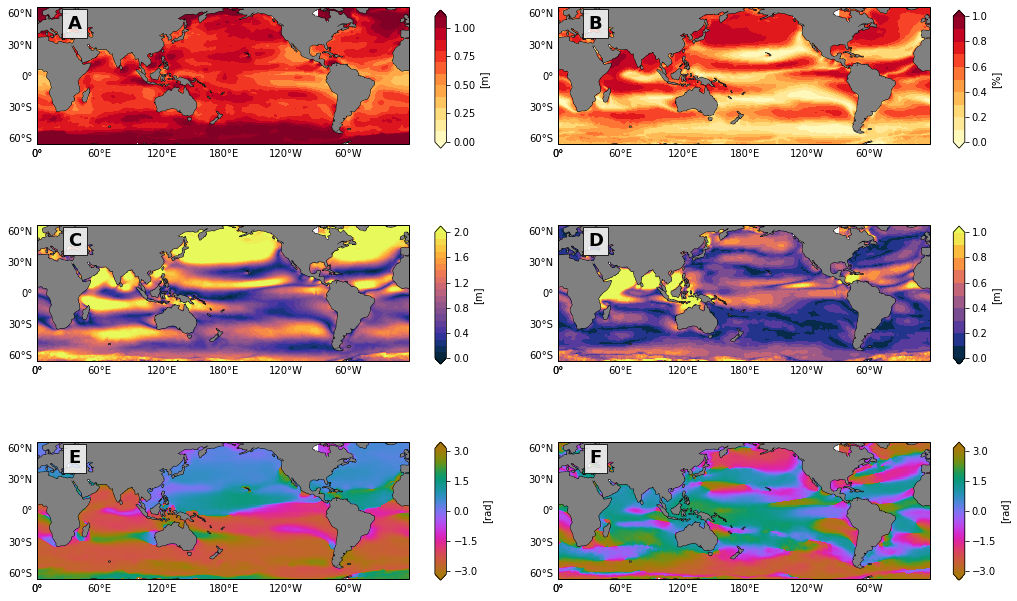

In [16]:
import cartopy.feature as cfeature

projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '110m'

fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

set_subplots_c(ax1, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
levels = np.arange(0.0, 1.2, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, wsp_rms_m, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
#left, bottom, width, height
cax1 = plt.axes([.47, .67, 0.01, 0.16])
set_cbar_c(cs1, cax1, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
set_subplots_c(ax2, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
levels = np.arange(0.0, 1.1, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, wsp_cod_m, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax2 = plt.axes([.92, .67, 0.01, 0.16])
set_cbar_c(cs2, cax2, fig, cbar_label ='[%]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
set_subplots_c(ax3, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
levels = np.arange(0.0, 2.1, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, wsp_amp1_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax3 = plt.axes([.47, .42, 0.01, 0.16])
set_cbar_c(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
set_subplots_c(ax4, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
levels = np.arange(0.0, 1.1, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, wsp_amp2_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax4 = plt.axes([.92, .42, 0.01, 0.16])
set_cbar_c(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

############## Subplot 5  #################
set_subplots_c(ax5, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
cs5 = ax5.pcolor(lon_c,lat_c,wsp_phase1_m,vmin=-pi,vmax=pi, cmap=cmo.phase, transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax5,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax5 = plt.axes([.47, .17, 0.01, 0.16])
set_cbar_c(cs5, cax5, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax5, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax5, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'E', fs_shade = 28, fs_main = 18)

############## Subplot 6  #################
set_subplots_c(ax6, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
cs6 = ax6.pcolor(lon_c,lat_c,wsp_phase2_m,vmin=-np.pi,vmax=np.pi, cmap=cmo.phase, transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax6,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax6 = plt.axes([.92, .17, 0.01, 0.16])
set_cbar_c(cs6, cax6, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax6, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax6, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'F', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.4, hspace = 0)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/WW3_wsp_lsf_characteristics_5_par_fit', bbox_inches = 'tight', dpi=300)

### SWH

###### RMS, Amplitude and Phase of annual cycle, Amplitude and phase of Semi-annual cycle, Coefficient of Determination subplot figure with Cartopy

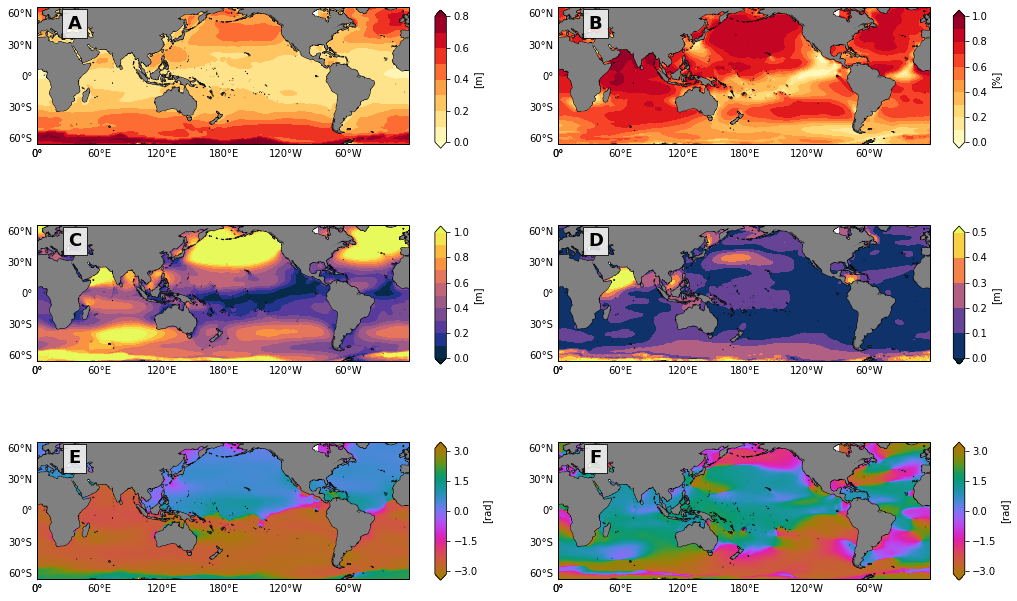

In [17]:
import cartopy.feature as cfeature

projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(3, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

set_subplots_c(ax1, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
levels = np.arange(0.0, 0.9, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, swh_rms_m, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
#left, bottom, width, height
cax1 = plt.axes([.47, .67, 0.01, 0.16])
set_cbar_c(cs1, cax1, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
set_subplots_c(ax2, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
levels = np.arange(0.0, 1.1, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, swh_cod_m, levels=levels, cmap=cm.YlOrRd,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax2 = plt.axes([.92, .67, 0.01, 0.16])
set_cbar_c(cs2, cax2, fig, cbar_label ='[%]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
set_subplots_c(ax3, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
levels = np.arange(0.0, 1.1, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, swh_amp1_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax3 = plt.axes([.47, .42, 0.01, 0.16])
set_cbar_c(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
set_subplots_c(ax4, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
levels = np.arange(0.0, 0.6, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, swh_amp2_m, levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax4 = plt.axes([.92, .42, 0.01, 0.16])
set_cbar_c(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)

############## Subplot 5  #################
set_subplots_c(ax5, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
cs5 = ax5.pcolor(lon_c, lat_c, swh_phase1_m, vmin=-pi,vmax=pi, cmap=cmo.phase, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax5,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax5 = plt.axes([.47, .17, 0.01, 0.16])
set_cbar_c(cs5, cax5, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax5, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax5, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'E', fs_shade = 28, fs_main = 18)

############## Subplot 6  #################
set_subplots_c(ax6, projection, resolution, lon_min = -180, lon_max = 179, lat_min = -66, lat_max = 66)
cs6 = ax6.pcolor(lon_c, lat_c, swh_phase2_m, vmin=-np.pi, vmax=np.pi, cmap=cmo.phase, 
                 transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax6,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color='black')
cax6 = plt.axes([.92, .17, 0.01, 0.16])
set_cbar_c(cs6, cax6, fig, cbar_label ='[rad]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax6, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
subplot_label_c(ax6, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'F', fs_shade = 28, fs_main = 18)

#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.4, hspace = 0)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/WW3_swh_lsf_characteristics_5_par_fit', bbox_inches = 'tight', dpi=300)

In [ ]:
print(time)

In [ ]:
print(lon.shape,lat.shape)
print(swh_rms_m.shape,wsp_rms_m.shape)


In [ ]:
print(lat_c,lon_c)

In [ ]:
lat_c[132] = 66.25
print(lat_c)

In [ ]:
#plot: 

plt.pcolor(lon_c,lat_c,wsp_array_dr[0,:,:],vmin=0,vmax=20, cmap=cm.viridis)
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[rad]', fontsize=14)
#label figure 
plt.title('Check binning of WW3 Hs', fontsize=16)

In [ ]:
wsp_test = wsp_c[3,:,:]
type(wsp_test)
wsp_mask = np.ma.getmask(wsp_test)
print(np.any(wsp_mask))
wsp_test[wsp_mask] = 0


In [ ]:
wsp_test_f = np.ma.masked_equal(wsp_test, 0)

In [ ]:
%whos

In [ ]:
%whos